# Create network from GPM transport data


In [1]:
import shapely.wkb
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import osmnx as ox

plt.rcParams['figure.figsize'] = (10, 10)

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_1738/2051798105.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shape

# Railways 

- ~~get lines and stations in IDF~~
- ~~only keep in-scope modes (RER and Metro)~~
- ~~remove stations/bits of lines outside of GPM~~
- clean up dataframe. Keep/add: 
    - name
    - length
    - speed
    - weight
    - position
    - mode
    - line
    

## Get Data

In [2]:
# Railway lines in IDF
# source: https://data.iledefrance-mobilites.fr/explore/dataset/traces-du-reseau-ferre-idf/map/?location=12,48.7271,2.28086&basemap=jawg.streets

lines = gpd.read_file("data/raw/traces-du-reseau-ferre-idf/traces-du-reseau-ferre-idf.shp").to_crs(2154)

# Only keep Metro and RER
lines = lines.loc[(lines['mode'] == 'METRO') 
                        | (lines['mode'] == 'RER')]

lines.columns

Index(['idrefliga', 'idrefligc', 'indice_lig', 'res_com', 'reseau', 'mode',
       'fer', 'train', 'rer', 'metro', 'tramway', 'navette', 'val', 'date_mes',
       'idf', 'extcode', 'shape_leng', 'colourweb_h', 'colourprint', 'picto',
       'picto_inter', 'picto_final', 'geometry'],
      dtype='object')

In [3]:
# Railway stations in IDF
# source: https://data.iledefrance-mobilites.fr/explore/dataset/emplacement-des-gares-idf/information/

stations = gpd.read_file("data/raw/emplacement-des-gares-idf/emplacement-des-gares-idf.shp").to_crs(2154)

# Only keep Metro and RER
stations = stations.loc[(stations['mode'] == 'METRO') 
                        | (stations['mode'] == 'RER')]

stations['res_com'].unique()

array(['RER A', 'RER C', 'RER E', 'RER D', 'RER B', 'METRO 1', 'METRO 9',
       'METRO 4', 'METRO 7bis', 'METRO 10', 'METRO 3', 'METRO 13',
       'METRO 14', 'METRO 7', 'METRO 6', 'METRO 12', 'METRO 11',
       'METRO 5', 'METRO 8', 'METRO 2', 'METRO 3bis'], dtype=object)

(622966.2013086217, 686932.8488897617, 6794027.13902586, 6912666.344766285)

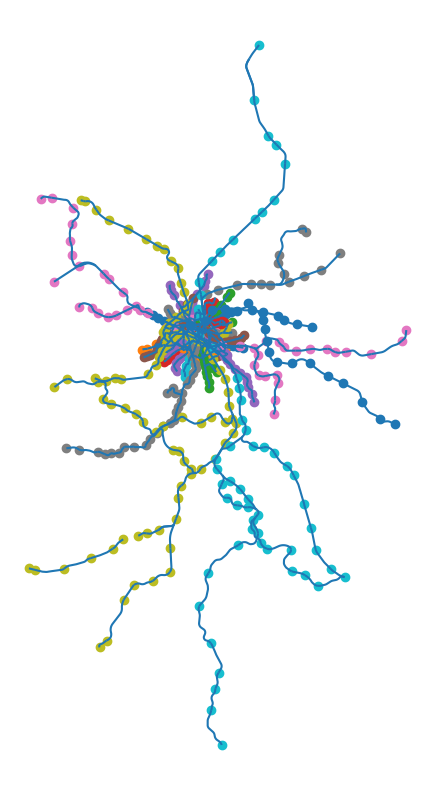

In [4]:
ax = plt.axes()
lines.groupby('reseau').plot(ax=ax)
stations.groupby('ligne').plot(ax=ax)
ax.axis('off')

## Filter for GPM

In [5]:
#--- Create same boundary as for the carbike network

# Get GPM boundary
GPM = gpd.read_file('data/raw/GPM.geojson')
GPM = GPM.to_crs(2154)

# Add a buffer
buffer_dist = 2000

# Get convex hull of the area
GPM_hull = gpd.GeoDataFrame({"geometry": GPM.convex_hull})
GPM_hull = GPM_hull.to_crs(GPM.crs)
# Buffer the convex hull
GPM_hull_buff = gpd.GeoDataFrame({"geometry": GPM_hull.buffer(buffer_dist)})
GPM_hull_buff = GPM_hull_buff.to_crs(GPM.crs)

ligne
METRO 1       Axes(0.18063,0.11;0.663739x0.77)
METRO 10      Axes(0.18063,0.11;0.663739x0.77)
METRO 11      Axes(0.18063,0.11;0.663739x0.77)
METRO 12      Axes(0.18063,0.11;0.663739x0.77)
METRO 13      Axes(0.18063,0.11;0.663739x0.77)
METRO 14      Axes(0.18063,0.11;0.663739x0.77)
METRO 2       Axes(0.18063,0.11;0.663739x0.77)
METRO 3       Axes(0.18063,0.11;0.663739x0.77)
METRO 3bis    Axes(0.18063,0.11;0.663739x0.77)
METRO 4       Axes(0.18063,0.11;0.663739x0.77)
METRO 5       Axes(0.18063,0.11;0.663739x0.77)
METRO 6       Axes(0.18063,0.11;0.663739x0.77)
METRO 7       Axes(0.18063,0.11;0.663739x0.77)
METRO 7bis    Axes(0.18063,0.11;0.663739x0.77)
METRO 8       Axes(0.18063,0.11;0.663739x0.77)
METRO 9       Axes(0.18063,0.11;0.663739x0.77)
RER A         Axes(0.18063,0.11;0.663739x0.77)
RER B         Axes(0.18063,0.11;0.663739x0.77)
RER C         Axes(0.18063,0.11;0.663739x0.77)
RER D         Axes(0.18063,0.11;0.663739x0.77)
RER E         Axes(0.18063,0.11;0.663739x0.77)
dtype: 

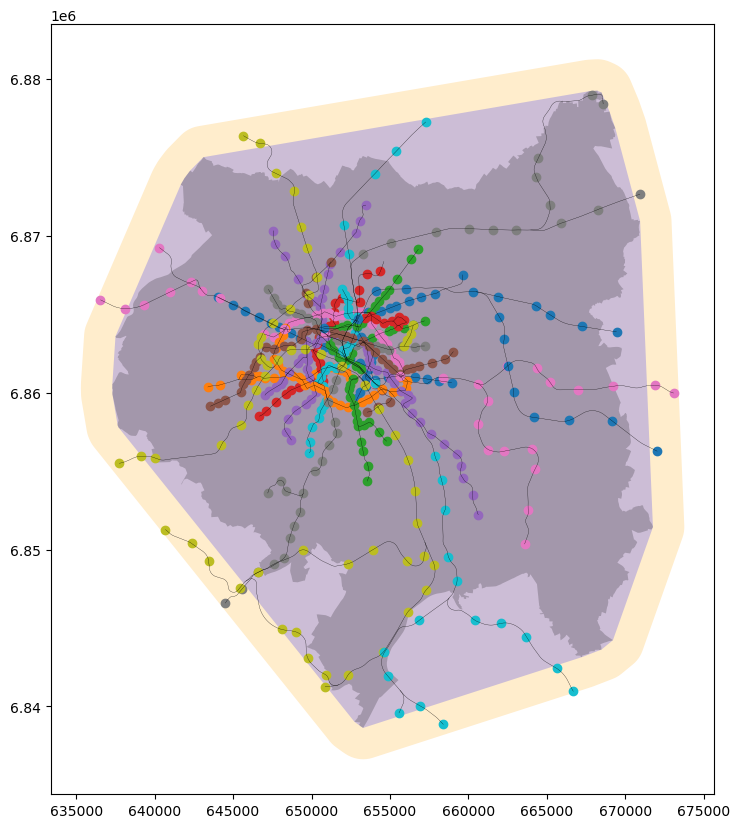

In [6]:
# Subset for lines and stations within the boundary
lines_GPM  = gpd.sjoin(lines, GPM_hull_buff, predicate = 'within')
stations_GPM = gpd.sjoin(stations, GPM_hull_buff, predicate = 'within')

ax = plt.axes()

GPM_hull_buff.plot(ax = ax, color = "orange", alpha=0.2)
GPM_hull.plot(ax = ax, color = "blue", alpha = 0.2)
GPM.plot(ax = ax, color = "black", alpha = 0.2)

lines_GPM.groupby('reseau').plot(ax=ax, linewidth = 0.2, color = 'black')
stations_GPM.groupby('ligne').plot(ax=ax)

## Clean Data

In [7]:
#--- Cleaning up the lines dataframe

# Keep the transport mode, transport line, length of edge and geometry columns
col_tokeep = ['reseau', 'mode', 'shape_leng', 'geometry']

lines_GPM_clean = lines_GPM[col_tokeep]
lines_GPM_clean.head(3)

,reseau,mode,shape_leng,geometry
13,RER C,RER,1638.919383,"LINESTRING (642349.149 6850387.488, 642388.731..."
25,RER C,RER,3226.805125,"LINESTRING (646607.166 6848552.723, 646609.324..."
26,RER C,RER,1825.559538,"LINESTRING (652321.161 6849093.100, 652365.670..."


In [8]:
#--- Cleaning up the stations dataframe
col_tokeep = ['mode', 'ligne', 'x', 'y', 'geometry']
stations_GPM_clean = stations_GPM[col_tokeep]
stations_GPM_clean.head(3)


,mode,ligne,x,y,geometry
2,RER,RER C,656121.8463,6.845998e+06,POINT (656121.846 6845998.147)
3,RER,RER A,650849.5187,6.863779e+06,POINT (650849.519 6863778.762)
7,RER,RER E,672031.7582,6.856264e+06,POINT (672031.758 6856263.686)


In [9]:
#--- Where possible, match stations with lines based on matching geometries
lines_GPM = lines_GPM_clean.to_crs(4326)
stations_GPM = stations_GPM_clean.to_crs(4326)

# Extract start and end coordinates of lines from the geometry column
lines_GPM['start'] = lines_GPM['geometry'].apply(lambda x: x.coords[0])
lines_GPM['end'] = lines_GPM['geometry'].apply(lambda x: x.coords[-1])

# Round the coordinates to 3 decimals
lines_GPM['start'] = lines_GPM['start'].apply(lambda x: (round(x[0], 3), round(x[1], 3)))
lines_GPM['end'] = lines_GPM['end'].apply(lambda x: (round(x[0], 3), round(x[1], 3)))

# Give IDs to the stations
stations_GPM = stations_GPM.reset_index(drop = True).reset_index(drop = False).rename(columns = {'index':'id'})

# In the stations dataframe, save the geometry as a tuple
stations_GPM['coord'] = stations_GPM['geometry'].apply(lambda x: (round(x.x, 3), round(x.y, 3)))

# Create a dictionary of the stations coordinate and id
stations_GPM = stations_GPM.reset_index(drop = True).rename(columns = {'index':'id'})
stations_dict = dict(zip(stations_GPM['coord'], stations_GPM['id']))

# Create a column in lines_GPM with the id of the start and end stations
lines_GPM['u'] = lines_GPM['start'].apply(lambda x: stations_dict[x] if x in stations_dict else np.nan)
lines_GPM['v'] = lines_GPM['end'].apply(lambda x: stations_dict[x] if x in stations_dict else np.nan)

lines_GPM.head(3)

,reseau,mode,shape_leng,geometry,start,end,u,v
13,RER C,RER,1638.919383,"LINESTRING (2.21586 48.75102, 2.21640 48.75078...","(2.216, 48.751)","(2.231, 48.741)",100.0,22.0
25,RER C,RER,3226.805125,"LINESTRING (2.27400 48.73489, 2.27403 48.73490...","(2.274, 48.735)","(2.313, 48.748)",220.0,7.0
26,RER C,RER,1825.559538,"LINESTRING (2.35163 48.74020, 2.35224 48.74032...","(2.352, 48.74)","(2.373, 48.748)",451.0,15.0


In [10]:
# Was this enough to match all stations with lines?
print("Number of stations: ", len(lines_GPM))
print("Number of START stations not matched with lines: ", len(lines_GPM) - len(lines_GPM['u'].dropna()))
print("Number of END stations not matched with lines: ", len(lines_GPM) - len(lines_GPM['v'].dropna()))

Number of stations:  549
Number of START stations not matched with lines:  21
Number of END stations not matched with lines:  22


In [12]:
#--- Where not filled thorugh matching, fill in u and v with the nearest station

from shapely.ops import nearest_points

def near(point, pts=stations_GPM.geometry.unary_union):
     # find the nearest point and return the corresponding Place value
     nearest = stations_GPM.geometry == nearest_points(point, pts)[1]
     return stations_GPM[nearest].id.values[0]

# Take care of the starting stations first
lines_GPM_start = lines_GPM.drop(columns = ['geometry'])
lines_GPM_start['geometry'] = lines_GPM_start['start'].apply(lambda x: shapely.geometry.Point(x))
lines_GPM_start = lines_GPM_start.set_geometry('geometry').set_crs(4326).drop(columns = ['start', 'end'])
lines_GPM_start['nearest'] = lines_GPM_start.apply(lambda row: near(row.geometry), axis=1)

# Repeat for the end stations
lines_GPM_end = lines_GPM.drop(columns = ['geometry'])
lines_GPM_end['geometry'] = lines_GPM_end['end'].apply(lambda x: shapely.geometry.Point(x))
lines_GPM_end = lines_GPM_end.set_geometry('geometry').set_crs(2154)
lines_GPM_end['nearest'] = lines_GPM_end.apply(lambda row: near(row.geometry), axis=1)

# Fill in the u and v column of lines_GPM with the u and v columns of lines_GPM_start and lines_GPM_end
lines_GPM['u'] = lines_GPM['u'].fillna(lines_GPM_start['nearest'])
lines_GPM['v'] = lines_GPM['v'].fillna(lines_GPM_end['nearest'])

# Check if all stations are matched with lines
print("Number of stations: ", len(lines_GPM))
print("Number of START stations not matched with lines: ", len(lines_GPM) - len(lines_GPM['u'].dropna()))
print("Number of END stations not matched with lines: ", len(lines_GPM) - len(lines_GPM['v'].dropna()))

Number of stations:  549
Number of START stations not matched with lines:  0
Number of END stations not matched with lines:  0


In [19]:
#--- Save for future use
stations_final = pd.DataFrame(stations_GPM.to_crs(2154).drop(columns = ['coord']))
stations_final.to_csv("./data/processed/public_transport_stations.csv")

lines_final = pd.DataFrame(lines_GPM.to_crs(2154).drop(columns = ['start', 'end']))
lines_final.to_csv("./data/processed/public_transport_lines.csv")

In [23]:
lines_GPM.loc[lines_GPM['u']== lines_GPM['v']]

,reseau,mode,shape_leng,geometry,start,end,u,v
28,RER C,RER,900.737445,"LINESTRING (2.41752 48.74507, 2.41756 48.74544...","(2.418, 48.745)","(2.418, 48.753)",208.0,208.0
64,RER A,RER,168.502709,"LINESTRING (2.22321 48.89575, 2.22310 48.89583...","(2.223, 48.896)","(2.222, 48.897)",327.0,327.0
170,RER C,RER,881.966706,"LINESTRING (2.34449 48.67078, 2.34506 48.67095...","(2.344, 48.671)","(2.352, 48.676)",16.0,16.0
198,RER E,RER,202.215865,"LINESTRING (2.45836 48.89665, 2.45999 48.89665...","(2.458, 48.897)","(2.461, 48.897)",111.0,111.0
557,RER B,RER,917.861438,"LINESTRING (2.49551 48.93220, 2.49684 48.93222...","(2.496, 48.932)","(2.508, 48.932)",102.0,102.0
840,METRO,METRO,47.405359,"LINESTRING (2.35971 48.81922, 2.35962 48.81928...","(2.36, 48.819)","(2.359, 48.82)",390.0,390.0
874,RER C,RER,339.677156,"LINESTRING (2.15684 48.79731, 2.15578 48.79704...","(2.157, 48.797)","(2.152, 48.797)",112.0,112.0
913,RER A,RER,678.061753,"LINESTRING (2.18535 48.92038, 2.18615 48.92000...","(2.185, 48.92)","(2.193, 48.917)",204.0,204.0
947,RER D,RER,1583.903520,"LINESTRING (2.39753 48.66792, 2.39888 48.66677...","(2.398, 48.668)","(2.397, 48.655)",356.0,356.0
1025,RER A,RER,144.238265,"LINESTRING (2.46170 48.84431, 2.46250 48.84410...","(2.462, 48.844)","(2.464, 48.844)",317.0,317.0


In [ ]:
# TODO
# the edges don't cleanly go from one station to the next, but rather follow the curve of the tracks.
# sometimes and edge is mistakenly identified as starting and ending at the same station
# it should only happen a few times but it needs to be fixed


#idea 1: move each nodes to its nearest edge (most won't be moved)
# somehow fusion the edges between nodes so that only one edge lies between any two connected nodes
